In [1]:
#IMPORTING LIBRARIES
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import zfit
import zfit.z.numpy as znp
import zfit_physics as zphysics 
from zfit import z  
import tensorflow as tf
import uproot

/Users/khrystina/new_env/lib/python3.11/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
#DOWLOADING DATASETS

files_simu = [
    './KJpsi_data/simu/2016_MagDown.root',
    './KJpsi_data/simu/2016_MagUp.root',
    # './KJpsi_data/simu/2017_MagDown.root',
    # './KJpsi_data/simu/2017_MagUp.root',
    # './KJpsi_data/simu/2018_MagDown.root',
    # './KJpsi_data/simu/2018_MagUp.root'
]

files_real_data = [
    './KJpsi_data/real/2016_MagDown.root', 
    './KJpsi_data/real/2016_MagUp.root',
    # './KJpsi_data/real/2017_MagDown.root', 
    # './KJpsi_data/real/2017_MagUp.root',
    # './KJpsi_data/real/2018_MagDown.root', 
    # './KJpsi_data/real/2018_MagUp.root'
]
simu_data = uproot.concatenate(files_simu, cut = 'Preselection==1', library='pd')
real_data = uproot.concatenate(files_real_data, cut = 'Preselection==1', library='pd')

In [3]:
def plot_model(model, data, min, max, scale=1, plot_data=True):  # we will use scale later on

    nbins = 500
    size_normal = len(data)
    lower, upper = data.data_range.limit1d
    x = znp.linspace(lower, upper, num=1000)  # np.linspace also works
    y = model.pdf(x) * size_normal / nbins * data.data_range.volume
    y *= scale
    plt.plot(x, y, label='model')
    plt.xlim(min, max)
    if plot_data:
        # legacy way, also works
        # data_plot = data.value()[:, 0]  # we could also use the `to_pandas` method
        # plt.hist(data_plot, bins=nbins)
        # modern way
        data_binned = data.to_binned(nbins)
        mplhep.histplot(data_binned, label='data')
    plt.legend()

In [63]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_with_pulls(model, data, min, max, scale=1, nbins=50, plot_data=True):
    
    size_normal = len(data)
    lower, upper = data.data_range.limit1d
    x = np.linspace(lower, upper, num=1000)

    # Evaluate model PDF
    y = model.pdf(x) * size_normal / nbins * data.data_range.volume
    y *= scale
    fig = plt.figure(figsize=(8, 6))

    from matplotlib.gridspec import GridSpec
    gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05) 

    # Upper subplot: Model and Data with error bars
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(x, y, label="model", color="blue", linewidth=1)
    ax1.set_xlim(min, max)

    if plot_data:
        # Bin the data
        data_binned = data.to_binned(nbins)
        bin_centers = data_binned.axes[0].centers
        bin_widths = data_binned.axes[0].widths
        data_counts = data_binned.values()
        data_uncertainties = np.sqrt(data_counts)  # Poisson errors

        ax1.errorbar(
            bin_centers, data_counts, yerr=data_uncertainties, fmt='o', 
            color='orange', label="data", markersize=1, capsize=6
        )

    ax1.legend()
    ax1.set_ylabel("Counts")
    ax1.set_title("Model vs. Data")
    ax1.grid()

    # Lower subplot: Pulls visualization
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    if plot_data:
        # Compute pulls
        model_at_bins = model.pdf(bin_centers) * size_normal / nbins * data.data_range.volume
        pulls = (data_counts - model_at_bins) / data_uncertainties

        ax2.errorbar(
            bin_centers, pulls, yerr=1, fmt='o', 
            color='purple', label="pulls", markersize=1, capsize=6
        )
        ax2.axhline(0, color='black', linestyle='--', linewidth=1)
        ax2.set_ylim(-15, 15) 
        ax2.set_ylabel("Pulls")
        ax2.grid()
        ax2.legend()

    ax2.set_xlabel("Observable")
    plt.tight_layout()
    plt.show()


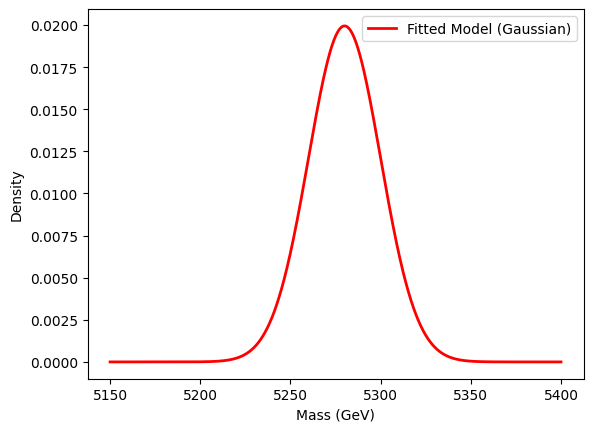

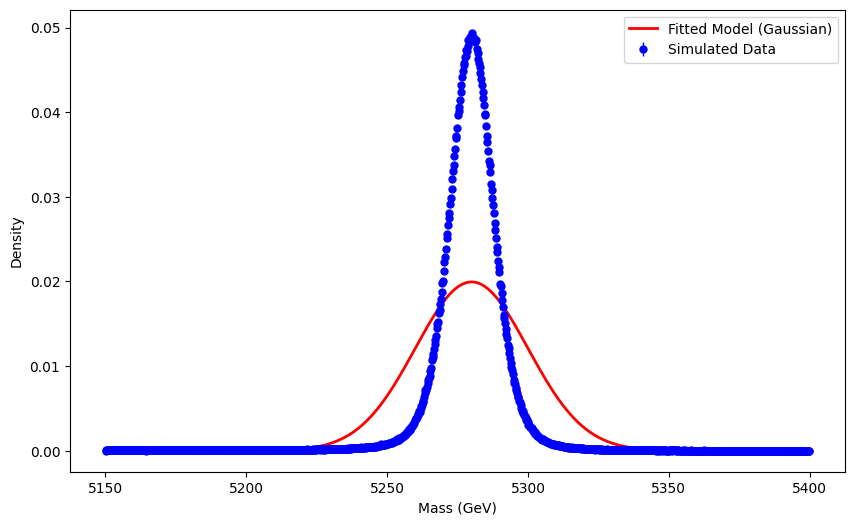

TypeError: plot_model() missing 2 required positional arguments: 'min' and 'max'

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep 
from zfit import z, models

# Set up the observable and model
obs = zfit.Space('mass', limits=(5150, 5400))  # Range for mass

# Parameters for Gaussian PDF (signal)
mu = zfit.Parameter("mu", 5280)
sigma = zfit.Parameter("sigma", 20)

# Define Gaussian PDF for signal
gauss = zfit.pdf.Gauss(obs=obs, mu=mu, sigma=sigma)

simu_mass = simu_data['B_JpsiDTF_M']
simu_mass_np = simu_mass.to_numpy()
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=obs)

nll = zfit.loss.UnbinnedNLL(model=gauss, data=simu_data_zfit)
minimizer = zfit.minimize.Minuit()

# Create the Gaussian PDF model for plotting
x_vals = np.linspace(5150, 5400, 1000)
y_vals = gauss.pdf(x_vals)

plt.plot(x_vals, y_vals, label="Fitted Model (Gaussian)", color='red', lw=2)

# Add labels and legend
plt.xlabel('Mass (GeV)')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plot simulated data as a histogram
plt.figure(figsize=(10, 6))
mplhep.histplot(simu_data_zfit.to_binned(1000), yerr=True, density=True, color='blue', histtype='errorbar', label="Simulated Data")
plt.plot(x_vals, y_vals, label="Fitted Model (Gaussian)", color='red', lw=2)
plt.xlabel('Mass (GeV)')
plt.ylabel('Density')
plt.legend()
plt.show()

plot_model(gauss, simu_data_zfit)

minimizer_minuit_1 = zfit.minimize.Minuit()
result_1 = minimizer_minuit_1.minimize(loss=nll, params=[mu, sigma])
print(result_1)

In [5]:
#FROM ZFIT DOCUMENTATION
mass_obs = zfit.Space('mass', limits=(5150, 5400))
# Signal component

mu_sig = zfit.Parameter('mu_sig', 5280, 5270, 5290)
sigma_sig = zfit.Parameter('sigma_sig', 12, 10, 15)
alpha_sig = zfit.Parameter('alpha_sig', 200, 100, 400, floating=False)  # won't be used in the fit
npar_sig = zfit.Parameter('n sig', 4, 0.1, 30, floating=False)

signal = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_sig, sigma=sigma_sig, alpha=alpha_sig, n=npar_sig)
# combinatorial background
lam = zfit.Parameter('lambda', -0.01, -0.05, -0.0001)

comb_bkg = zfit.pdf.Exponential(lam, obs=mass_obs)

simu_mass = simu_data['B_JpsiDTF_M']
simu_mass_np = simu_mass.to_numpy()
part_reco = zfit.pdf.KDE1DimGrid(obs=mass_obs, data=simu_mass_np)

before: <zfit.Parameter 'sig_frac' floating=True value=0.3>
new value: <zfit.Parameter 'sig_frac' floating=True value=0.25>
after 'with': <zfit.Parameter 'sig_frac' floating=True value=0.3>
FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.Data: Data obs=('mass',) shape=(2360305, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 3.1e-09 │       9232358.03 | -429750.9 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
mu                 5279.46       False
sigma              12.0923       False


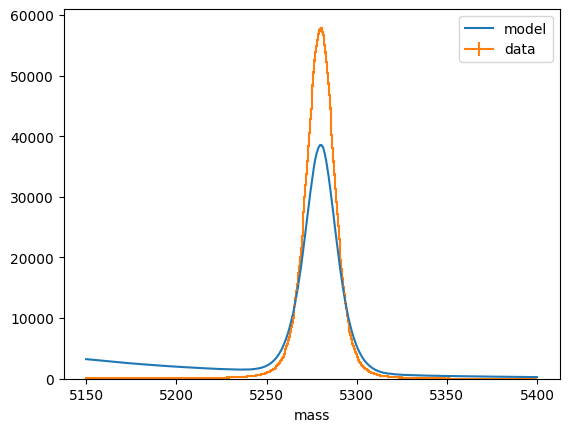

In [6]:
sig_frac = zfit.Parameter('sig_frac', 0.3, 0, 1)
comb_bkg_frac = zfit.Parameter('comb_bkg_frac', 0.25, 0, 1)
model = zfit.pdf.SumPDF([signal, comb_bkg, part_reco], [sig_frac, comb_bkg_frac])
print(f"before: {sig_frac}")
with sig_frac.set_value(0.25):
    print(f"new value: {sig_frac}")
print(f"after 'with': {sig_frac}")
# #generates a sample of 10000 events from the composite model:
# with zfit.param.set_values([mu_sig, sigma_sig, sig_frac, comb_bkg_frac, lam], [5280, 20, 0.08, 0.31, -0.0025]):
#     data = model.sample(n=10_000)
plot_model(model, simu_data_zfit)
# In the case of a Gaussian (e.g.)
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll, params=[mu, sigma])
print(result)

before: <zfit.Parameter 'sig_frac' floating=True value=0.3>
new value: <zfit.Parameter 'sig_frac' floating=True value=0.25>
after 'with': <zfit.Parameter 'sig_frac' floating=True value=0.3>
FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.dist_tfp.Gauss'>  params=[mu, sigma]] data=[<zfit.Data: Data obs=('mass',) shape=(2360305, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 3.1e-09 │       9232358.03 | -429750.9 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
mu                 5279.46       False
sigma              12.0923       False


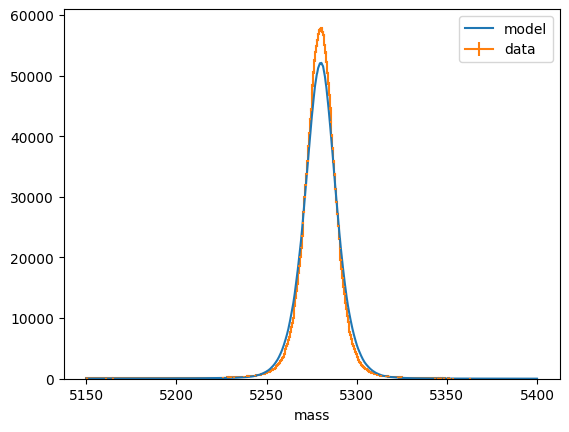

In [7]:
sig_frac = zfit.Parameter('sig_frac', 0.3, 0, 1)
model = zfit.pdf.SumPDF([signal, part_reco], [sig_frac])
print(f"before: {sig_frac}")
with sig_frac.set_value(0.25):
    print(f"new value: {sig_frac}")
print(f"after 'with': {sig_frac}")
# #generates a sample of 10000 events from the composite model:
# with zfit.param.set_values([mu_sig, sigma_sig, sig_frac, comb_bkg_frac, lam], [5280, 20, 0.08, 0.31, -0.0025]):
#     data = model.sample(n=10_000)
plot_model(model, simu_data_zfit)
# In the case of a Gaussian (e.g.)
minimizer_minuit_2 = zfit.minimize.Minuit()
result_2 = minimizer_minuit_2.minimize(loss=nll)
print(result_2)

1
2
3
4
5
FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.physics.CrystalBall'>  params=[alpha_sig, mu_sig, n sig, sigma_sig]] data=[<zfit.Data: Data obs=('mass',) shape=(2360305, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═══════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm  │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═══════╪══════════════════════════════╡
│  True   │    True     │      False       │ 6e-05 │       8905765.94 | -123284.3 │
╘═════════╧═════════════╧══════════════════╧═══════╧══════════════════════════════╛

Parameters
name         value  (rounded)    at limit
---------  ------------------  ----------
mu_sig                5280.24       False
sigma_sig             9.73733       False
alpha_sig             2.38596       False
n sig                 1.45078       False


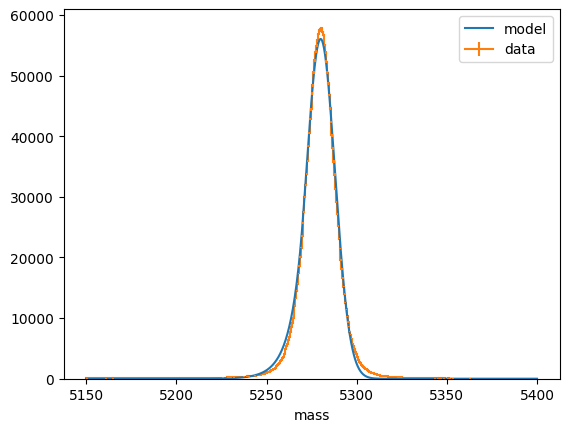

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import mplhep 
from zfit import z, models

# Parameters for Gaussian PDF (signal)

simu_mass = simu_data['B_JpsiDTF_M']
print("1")
simu_mass_np = simu_mass.to_numpy()
print("2")
mass_obs = zfit.Space('mass', limits=(5150, 5400))
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)
# Signal component
print("3")
mu_sig = zfit.Parameter('mu_sig', 5280, 5270, 5290)
sigma_sig = zfit.Parameter('sigma_sig', 8, 0.1, 15)
alpha_sig = zfit.Parameter('alpha_sig', 1.2, 1.0, 30, floating=True)
npar_sig = zfit.Parameter('n sig', 51, 0.1, 60, floating=True)

print("4")
signal = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_sig, sigma=sigma_sig, alpha=alpha_sig, n=npar_sig)

nll = zfit.loss.UnbinnedNLL(model=signal, data=simu_data_zfit)
minimizer = zfit.minimize.Minuit()

print("5")

plot_model(signal, simu_data_zfit)
# In the case of a Gaussian (e.g.)
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll)
print(result)

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_3729/1057157104.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


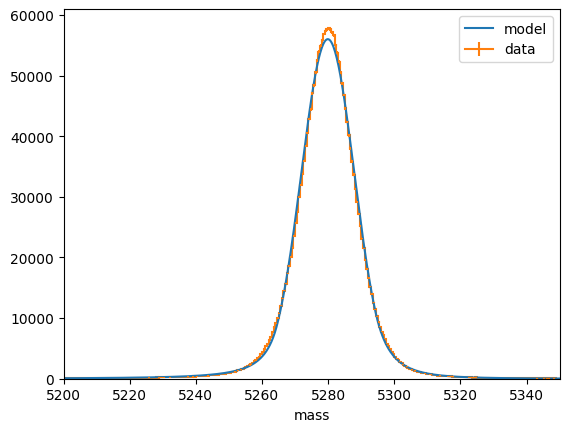

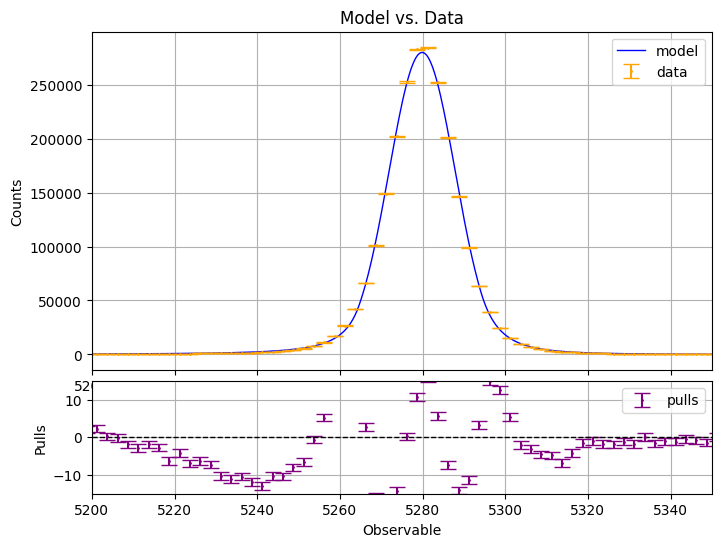

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.physics.DoubleCB'>  params=[alpha_l, alpha_r, mu, n_l, n_r, sigma]] data=[<zfit.Data: Data obs=('mass',) shape=(2360305, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 1.6e-05 │       8758236.17 |  9997.656 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name       value  (rounded)    at limit
-------  ------------------  ----------
mu                  5279.89       False
sigma               8.00908       False
alpha_l             1.92288       False
n_l                 2.29312       False
alpha_r             1.80103       False
n_r                 4.11925       False


In [26]:
#DOUBLE CRYSTAL BALL
simu_mass = simu_data['B_JpsiDTF_M']
simu_mass_np = simu_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(5150, 5400))
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)
# Signal component
mu = zfit.Parameter('mu', 5279.9, 5270, 5290)
sigma = zfit.Parameter('sigma', 8.0, 0.1, 15)
alpha_l = zfit.Parameter('alpha_l', 1.92, 1.0, 30, floating=True)
npar_l = zfit.Parameter('n_l', 2.29, 0.1, 60, floating=True)
alpha_r = zfit.Parameter('alpha_r', 1.8, 1.0, 30, floating=True)
npar_r = zfit.Parameter('n_r', 4.12, 0.1, 60, floating=True)

doubleCB = zfit.pdf.DoubleCB(obs=mass_obs, mu=mu, sigma=sigma, alphal=alpha_l, nl=npar_l, alphar=alpha_r, nr=npar_r)

nll = zfit.loss.UnbinnedNLL(model=doubleCB, data=simu_data_zfit)
minimizer = zfit.minimize.Minuit()

plot_model(doubleCB, simu_data_zfit, 5200, 5350)
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll)
plot_model_with_pulls(doubleCB, simu_data_zfit, 5200, 5350, nbins=100)
print(result)

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_3729/1057157104.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


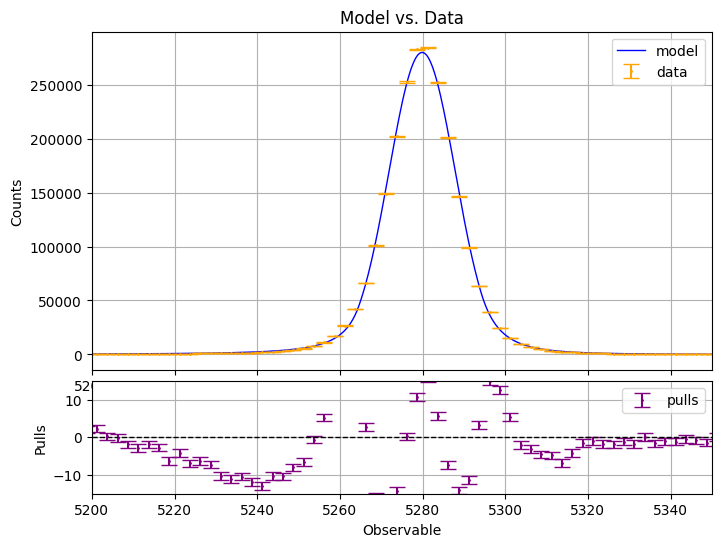

In [40]:
plot_model_with_pulls(doubleCB, simu_data_zfit, 5200, 5350, nbins=100)

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_3729/1057157104.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


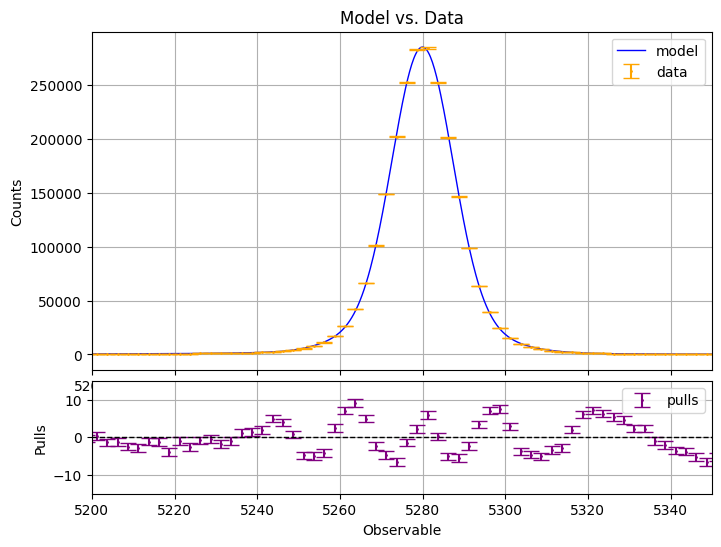

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[CB1_frac, Composed_autoparam_19, Gauss_frac]] data=[<zfit.Data: Data obs=('mass',) shape=(2360305, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 6.6e-05 │       8755922.98 | -2012.674 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name          value  (rounded)    at limit
----------  ------------------  ----------
CB1_frac             0.0111387       False
Gauss_frac             0.76058       False
mu_cb1                    5295       False
sigma1                 38.2235       False
alpha_1                   23.2       False
n_1                

In [30]:
#GAUSS AND TWO CRYSTALBALLS
simu_mass = simu_data['B_JpsiDTF_M']
simu_mass_np = simu_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(5150, 5400))
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)

mu_g = zfit.Parameter('mu_g', 5279, 5279, 5290)
mu_cb1 = zfit.Parameter('mu_cb1', 5294, 5279, 6000)
mu_cb2 = zfit.Parameter('mu_cb2', 5279, 5279, 5290)
sigma = zfit.Parameter('sigma', 7.22, 0.1, 15)
sigma_1 = zfit.Parameter('sigma1', 38.24, 0.1, 70)
sigma_2 = zfit.Parameter('sigma2', 14.34, 0.1, 15)
alpha_1 = zfit.Parameter('alpha_1', 23.2, 0.1, 30)
n_1 = zfit.Parameter('n_1', 11.8, 0.1, 90)
alpha_2 = zfit.Parameter('alpha_2', 2.17, 1.0, 30)
n_2 = zfit.Parameter('n_2', 0.98, 0.1, 60)

Gauss = zfit.pdf.Gauss(obs=mass_obs, mu=mu_g, sigma=sigma)
CrystalBall_1 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb1, sigma=sigma_1, alpha=alpha_1, n=n_1)
CrystalBall_2 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb2, sigma=sigma_2, alpha=alpha_2, n=n_2)

Gauss_frac = zfit.Parameter('Gauss_frac', 0.76, 0, 1)
CB1_frac = zfit.Parameter('CB1_frac', 0.011, 0, 1)
supermodel = zfit.pdf.SumPDF([CrystalBall_1, Gauss, CrystalBall_2], [CB1_frac, Gauss_frac])

nll = zfit.loss.UnbinnedNLL(model=supermodel, data=simu_data_zfit)
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll)

plot_model_with_pulls(supermodel, simu_data_zfit, 5200, 5350, nbins=100)
# minimizer_minuit = zfit.minimize.Minuit()
# result = minimizer_minuit.minimize(loss=nll)
print(result)

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_3729/1057157104.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


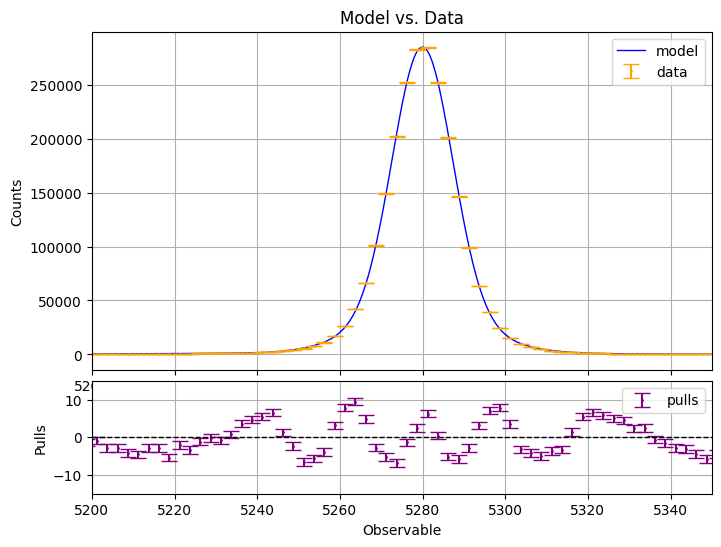

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[CB1_frac, Composed_autoparam_31, Gauss_frac]] data=[<zfit.Data: Data obs=('mass',) shape=(2360305, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.0002 │        8755989.45 | -3432.53 │
╘═════════╧═════════════╧══════════════════╧════════╧══════════════════════════════╛

Parameters
name          value  (rounded)    at limit
----------  ------------------  ----------
CB1_frac             0.0162957       False
Gauss_frac            0.766222       False
mu_g                   5279.99       False
sigma1                 42.5097       False
alpha_1                   23.2       False
n_1                     

In [43]:
#GAUSS AND TWO CRYSTALBALLS cb_1 and gauss are sharing mu
simu_mass = simu_data['B_JpsiDTF_M']
simu_mass_np = simu_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(5150, 5400))
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)

mu_g = zfit.Parameter('mu_g', 5279, 5279, 5290)
mu_cb2 = zfit.Parameter('mu_cb2', 5279, 5279, 5290)
sigma = zfit.Parameter('sigma', 7.22, 0.1, 15)
sigma_1 = zfit.Parameter('sigma1', 38.24, 0.1, 70)
sigma_2 = zfit.Parameter('sigma2', 14.34, 0.1, 15)
alpha_1 = zfit.Parameter('alpha_1', 23.2, 0.1, 30)
n_1 = zfit.Parameter('n_1', 11.8, 0.1, 90)
alpha_2 = zfit.Parameter('alpha_2', 2.17, 1.0, 30)
n_2 = zfit.Parameter('n_2', 0.98, 0.1, 60)

Gauss = zfit.pdf.Gauss(obs=obs, mu=mu_g, sigma=sigma)
CrystalBall_1 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_g, sigma=sigma_1, alpha=alpha_1, n=n_1)
CrystalBall_2 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb2, sigma=sigma_2, alpha=alpha_2, n=n_2)

Gauss_frac = zfit.Parameter('Gauss_frac', 0.76, 0, 1)
CB1_frac = zfit.Parameter('CB1_frac', 0.011, 0, 1)
supermodel = zfit.pdf.SumPDF([CrystalBall_1, Gauss, CrystalBall_2], [CB1_frac, Gauss_frac])

nll = zfit.loss.UnbinnedNLL(model=supermodel, data=simu_data_zfit)
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll)

plot_model_with_pulls(supermodel, simu_data_zfit, 5200, 5350, nbins=100)
# minimizer_minuit = zfit.minimize.Minuit()
# result = minimizer_minuit.minimize(loss=nll)
print(result)

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_3729/1057157104.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


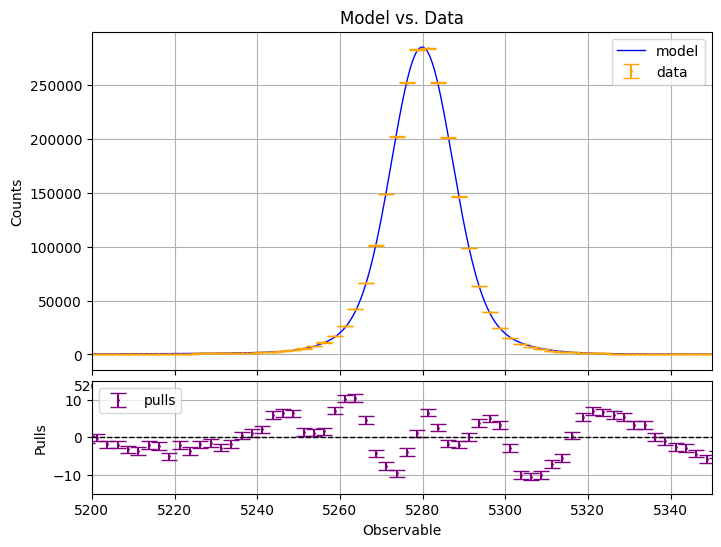

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[CB1_frac, Composed_autoparam_30, Gauss_frac]] data=[<zfit.Data: Data obs=('mass',) shape=(2360305, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.00015 │       8756143.47 | -1792.179 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name          value  (rounded)    at limit
----------  ------------------  ----------
CB1_frac             0.0117202       False
Gauss_frac            0.753198       False
mu_cb1                 5290.71       False
sigma1                 40.6008       False
alpha_1                   23.2       False
n_1                

In [42]:
#GAUSS AND TWO CRYSTALBALLS cb_2 and gauss are sharing mu
simu_mass = simu_data['B_JpsiDTF_M']
simu_mass_np = simu_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(5150, 5400))
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)

mu_g = zfit.Parameter('mu_g', 5279, 5279, 5290)
mu_cb1 = zfit.Parameter('mu_cb1', 5294, 5279, 6000)
sigma = zfit.Parameter('sigma', 7.22, 0.1, 15)
sigma_1 = zfit.Parameter('sigma1', 38.24, 0.1, 70)
sigma_2 = zfit.Parameter('sigma2', 14.34, 0.1, 15)
alpha_1 = zfit.Parameter('alpha_1', 23.2, 0.1, 30)
n_1 = zfit.Parameter('n_1', 11.8, 0.1, 90)
alpha_2 = zfit.Parameter('alpha_2', 2.17, 1.0, 30)
n_2 = zfit.Parameter('n_2', 0.98, 0.1, 60)

Gauss = zfit.pdf.Gauss(obs=obs, mu=mu_g, sigma=sigma)
CrystalBall_1 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb1, sigma=sigma_1, alpha=alpha_1, n=n_1)
CrystalBall_2 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_g, sigma=sigma_2, alpha=alpha_2, n=n_2)

Gauss_frac = zfit.Parameter('Gauss_frac', 0.76, 0, 1)
CB1_frac = zfit.Parameter('CB1_frac', 0.011, 0, 1)
supermodel = zfit.pdf.SumPDF([CrystalBall_1, Gauss, CrystalBall_2], [CB1_frac, Gauss_frac])

nll = zfit.loss.UnbinnedNLL(model=supermodel, data=simu_data_zfit)
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll)

plot_model_with_pulls(supermodel, simu_data_zfit, 5200, 5350, nbins=100)
# minimizer_minuit = zfit.minimize.Minuit()
# result = minimizer_minuit.minimize(loss=nll)
print(result)

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_3729/1057157104.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


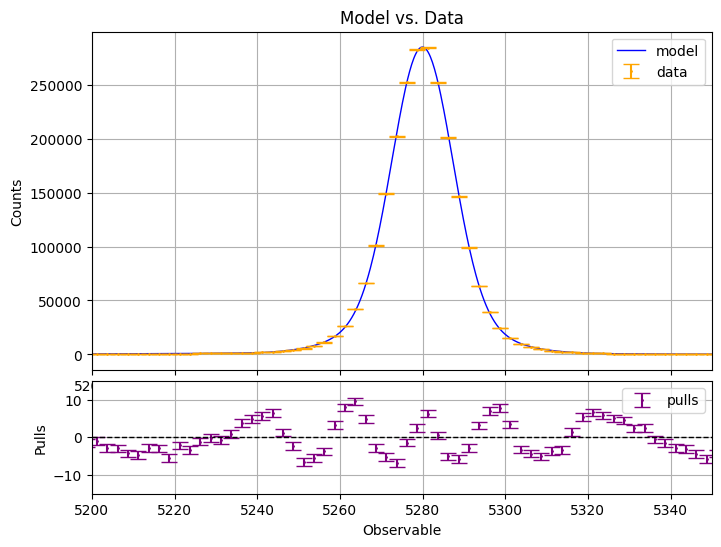

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[CB1_frac, Composed_autoparam_29, Gauss_frac]] data=[<zfit.Data: Data obs=('mass',) shape=(2360305, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.00029 │       8755995.66 | -96842.28 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name          value  (rounded)    at limit
----------  ------------------  ----------
CB1_frac             0.0165311       False
Gauss_frac            0.766324       False
mu_cb1                 5279.32       False
sigma1                 42.7219       False
alpha_1                   23.2       False
n_1                

In [41]:
#GAUSS AND TWO CRYSTALBALLS cbs are sharing mu
simu_mass = simu_data['B_JpsiDTF_M']
simu_mass_np = simu_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(5150, 5400))
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)

mu_g = zfit.Parameter('mu_g', 5279, 5279, 5290)
mu_cb = zfit.Parameter('mu_cb1', 5294, 5279, 6000)
sigma = zfit.Parameter('sigma', 7.22, 0.1, 15)
sigma_1 = zfit.Parameter('sigma1', 38.24, 0.1, 70)
sigma_2 = zfit.Parameter('sigma2', 14.34, 0.1, 15)
alpha_1 = zfit.Parameter('alpha_1', 23.2, 0.1, 30)
n_1 = zfit.Parameter('n_1', 11.8, 0.1, 90)
alpha_2 = zfit.Parameter('alpha_2', 2.17, 1.0, 30)
n_2 = zfit.Parameter('n_2', 0.98, 0.1, 60)

Gauss = zfit.pdf.Gauss(obs=obs, mu=mu_g, sigma=sigma)
CrystalBall_1 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb, sigma=sigma_1, alpha=alpha_1, n=n_1)
CrystalBall_2 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb, sigma=sigma_2, alpha=alpha_2, n=n_2)

Gauss_frac = zfit.Parameter('Gauss_frac', 0.76, 0, 1)
CB1_frac = zfit.Parameter('CB1_frac', 0.011, 0, 1)
supermodel = zfit.pdf.SumPDF([CrystalBall_1, Gauss, CrystalBall_2], [CB1_frac, Gauss_frac])

nll = zfit.loss.UnbinnedNLL(model=supermodel, data=simu_data_zfit)
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll)

plot_model_with_pulls(supermodel, simu_data_zfit, 5200, 5350, nbins=100)
# minimizer_minuit = zfit.minimize.Minuit()
# result = minimizer_minuit.minimize(loss=nll)
print(result)

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_3729/1057157104.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


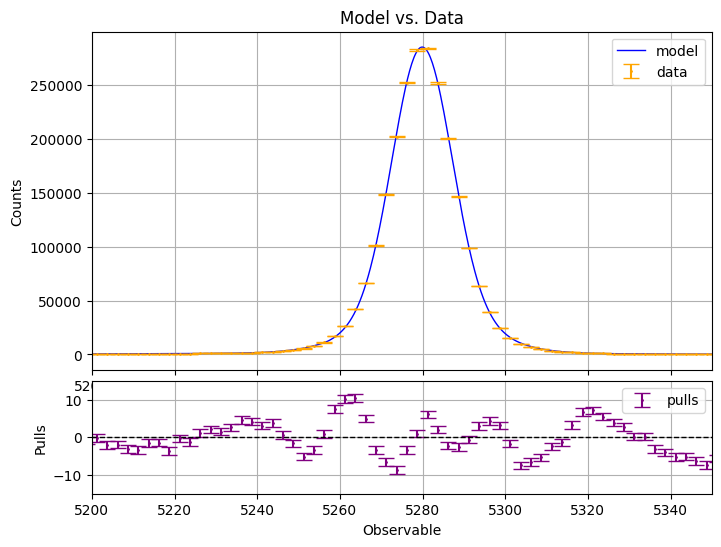

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_8, frac_cb, frac_core]] data=[<zfit.Data: Data obs=('mass',) shape=(2360305, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 1.8e-06 │       8756030.15 |  9862.564 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name          value  (rounded)    at limit
----------  ------------------  ----------
frac_cb               0.739648       False
frac_core             0.240576       False
mu                      5279.9       False
sigma_cb               7.13531       False
alpha_cb               3.15239       False
n_cb                  

In [16]:
#CRYSTALBALL + TWO GAUSSIANS
import zfit
import numpy as np
import matplotlib.pyplot as plt

# Define observable space
mass_obs = zfit.Space('mass', limits=(5150, 5400))

# Define parameters for the core Gaussian
mu = zfit.Parameter('mu', 5280, 5270, 5290)
sigma_core = zfit.Parameter('sigma_core',13.37, 0.1, 15)

# Define parameters for the Crystal Ball
sigma_cb = zfit.Parameter('sigma_cb', 7.14, 0.1, 15)
alpha_cb = zfit.Parameter('alpha_cb', 3.15, 1.0, 30)
n_cb = zfit.Parameter('n_cb', 0.42, 0.1, 60)

# Define parameters for the second Gaussian
sigma_wide = zfit.Parameter('sigma_wide', 40.1, 1.0, 50)

# Fractions for the combined model
frac_core = zfit.Parameter('frac_core', 0.24, 0, 1)
frac_cb = zfit.Parameter('frac_cb', 0.74, 0, 1)

# Define individual PDFs
gaussian_core = zfit.pdf.Gauss(obs=mass_obs, mu=mu, sigma=sigma_core)
gaussian_wide = zfit.pdf.Gauss(obs=mass_obs, mu=mu, sigma=sigma_wide)
crystal_ball = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu, sigma=sigma_cb, alpha=alpha_cb, n=n_cb)

# Combine the PDFs into a single model
combined_model = zfit.pdf.SumPDF([crystal_ball, gaussian_core, gaussian_wide], [frac_cb, frac_core])

# Load data
simu_mass = simu_data['B_JpsiDTF_M']
simu_mass_np = simu_mass.to_numpy()
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)

# Define the negative log-likelihood
nll = zfit.loss.UnbinnedNLL(model=combined_model, data=simu_data_zfit)

# Minimize using Minuit
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(loss=nll)

# Plot the model with pulls
plot_model_with_pulls(combined_model, simu_data_zfit, 5200, 5350, nbins=100)

# Print fit results
print(result)


/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_3729/1057157104.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


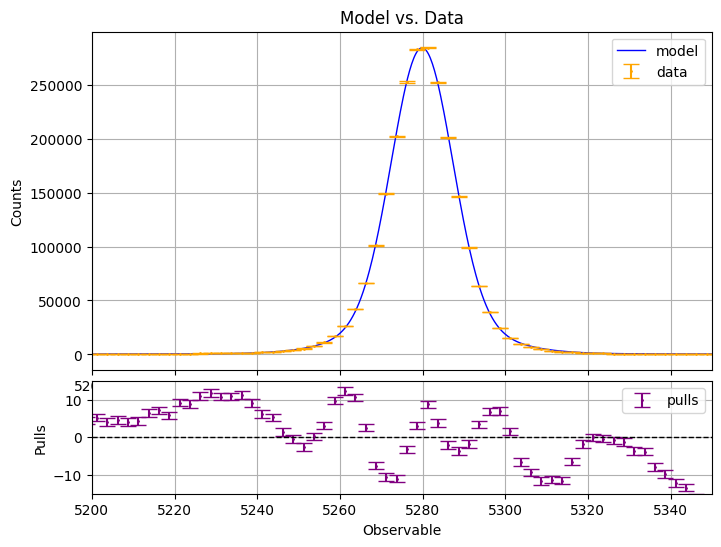

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_15, frac1, frac2]] data=[<zfit.Data: Data obs=('mass',) shape=(2360305, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═══════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm  │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═══════╪══════════════════════════════╡
│  True   │    True     │      False       │ 6e-05 │       8759233.24 |  9751.884 │
╘═════════╧═════════════╧══════════════════╧═══════╧══════════════════════════════╛

Parameters
name      value  (rounded)    at limit
------  ------------------  ----------
frac1             0.791714       False
frac2             0.189143       False
mu                 5279.88       False
sigma1             7.33948       False
sigma2              15.126       False
sigma3             65.3402       False


In [23]:
#TRIPLE GAUSSIAN

import zfit
import numpy as np
import matplotlib.pyplot as plt

# Define observable space
mass_obs = zfit.Space('mass', limits=(5150, 5400))

# Define parameters for the three Gaussians
mu = zfit.Parameter('mu', 5280, 5275, 5290)

# First Gaussian (core)
sigma1 = zfit.Parameter('sigma1', 7.34, 0.1, 15)

# Second Gaussian (slightly wider)
sigma2 = zfit.Parameter('sigma2', 15.13, 0.1, 25)

# Third Gaussian (widest)
sigma3 = zfit.Parameter('sigma3', 65.3, 0.1, 100)

# Fractions for combining the Gaussians
frac1 = zfit.Parameter('frac1', 0.79, 0, 1)  # Fraction of the first Gaussian
frac2 = zfit.Parameter('frac2', 0.19, 0, 1)  # Fraction of the second Gaussian

# Define individual Gaussian PDFs
gauss1 = zfit.pdf.Gauss(obs=mass_obs, mu=mu, sigma=sigma1)
gauss2 = zfit.pdf.Gauss(obs=mass_obs, mu=mu, sigma=sigma2)
gauss3 = zfit.pdf.Gauss(obs=mass_obs, mu=mu, sigma=sigma3)

# Combine the Gaussians into a single model
# Note: The third fraction is implicitly `1 - frac1 - frac2`
triple_gauss = zfit.pdf.SumPDF([gauss1, gauss2, gauss3], [frac1, frac2])

# Load data
simu_mass = simu_data['B_JpsiDTF_M']
simu_mass_np = simu_mass.to_numpy()
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)

# Define the negative log-likelihood
nll = zfit.loss.UnbinnedNLL(model=triple_gauss, data=simu_data_zfit)

# Minimize using Minuit
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(loss=nll)

# Plot the model with pulls
plot_model_with_pulls(triple_gauss, simu_data_zfit, 5200, 5350, nbins=100)

# Print fit results
print(result)


/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_3729/1057157104.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


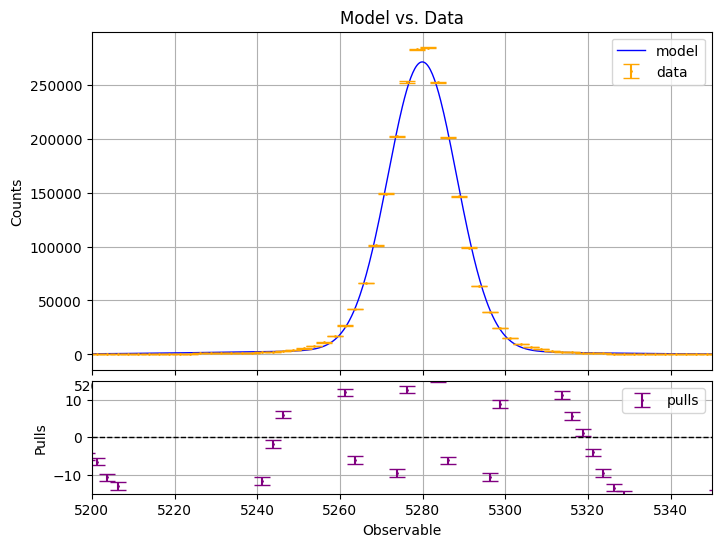

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_28, DCB_frac]] data=[<zfit.Data: Data obs=('mass',) shape=(2360305, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 7.4e-07 │       8770377.62 | -4138.758 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name         value  (rounded)    at limit
---------  ------------------  ----------
DCB_frac             0.944326       False
mu_dcb                5279.93       False
sigma_dcb             8.30516       False
alpha_1                  23.2       False
n_1                      11.8       False
alpha_2                 15.86       Fa

In [39]:
#ONE DOUBLECB AND ONE GAUSSIAN

simu_mass = simu_data['B_JpsiDTF_M']
simu_mass_np = simu_mass.to_numpy()
mass_obs = zfit.Space('mass', limits=(5150, 5400))
simu_data_zfit = zfit.data.Data.from_numpy(array=simu_mass_np, obs=mass_obs)

mu_g = zfit.Parameter('mu_g', 5279, 5210, 5290)
mu_dcb = zfit.Parameter('mu_dcb', 5279, 5000, 6000)
sigma = zfit.Parameter('sigma', 38.3, 0.1, 50)
sigma_dcb = zfit.Parameter('sigma_dcb', 8.4, 0.1, 20)
alpha_1 = zfit.Parameter('alpha_1', 23.2, 0.1, 30)
n_1 = zfit.Parameter('n_1', 11.8, 0.1, 30)
alpha_2 = zfit.Parameter('alpha_2', 15.86, 0.1, 30)
n_2 = zfit.Parameter('n_2', 3.55, 0.1, 20)

Gauss = zfit.pdf.Gauss(obs=obs, mu=mu_g, sigma=sigma)
DoubleCB = zfit.pdf.DoubleCB(obs=mass_obs, mu=mu_dcb, sigma=sigma_dcb, alphal=alpha_1, nl=n_1, alphar=alpha_2, nr=n_2)

DCB_frac = zfit.Parameter('DCB_frac', 0.94, 0, 1)
supermodel = zfit.pdf.SumPDF([DoubleCB, Gauss], [DCB_frac])

nll = zfit.loss.UnbinnedNLL(model=supermodel, data=simu_data_zfit)
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll)

plot_model_with_pulls(supermodel, simu_data_zfit, 5200, 5350, nbins=100)
# minimizer_minuit = zfit.minimize.Minuit()
# result = minimizer_minuit.minimize(loss=nll)
print(result)

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_977/1057157104.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


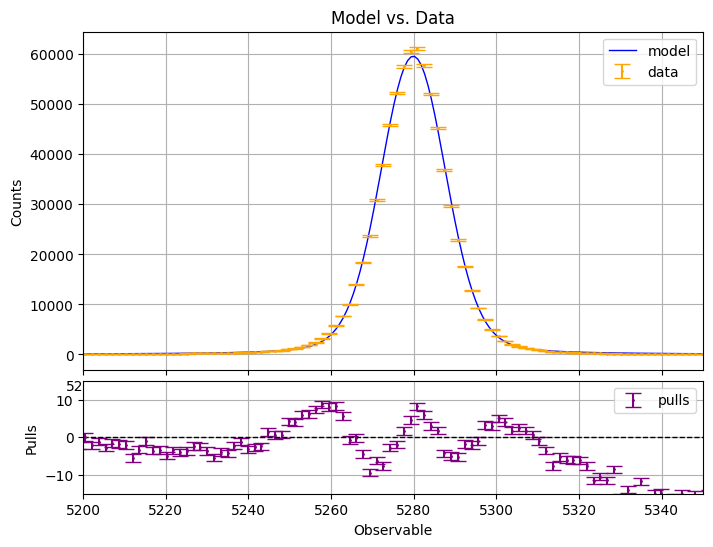

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.basic.Voigt'>  params=[gamma_voigt, mu_voigt, sigma_voigt]] data=[<zfit.Data: Data obs=('mass',) shape=(764715, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 2.2e-06 │       2833249.28 |  6093.119 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name           value  (rounded)    at limit
-----------  ------------------  ----------
mu_voigt                5279.86       False
sigma_voigt             7.19098       False
gamma_voigt             1.58936       False


In [71]:
#________VOIGT___________

# Parameters for the Voigt profile
mu_voigt = zfit.Parameter('mu_voigt', 5279, 5279, 5290)
sigma_voigt = zfit.Parameter('sigma_voigt', 7.44, 0.1, 15)
gamma_voigt = zfit.Parameter('gamma_voigt', 1.32, 0, 50)

# Define the PDF (Voigt profile)
Voigt = zfit.pdf.Voigt(obs=mass_obs, m=mu_voigt, sigma=sigma_voigt, gamma=gamma_voigt)

# Loss function (Unbinned NLL)
nll_voigt = zfit.loss.UnbinnedNLL(model=Voigt, data=simu_data_zfit)

# Minimizer
minimizer_minuit = zfit.minimize.Minuit()
result_voigt = minimizer_minuit.minimize(loss=nll_voigt)

# Plot result
plot_model_with_pulls(Voigt, simu_data_zfit, 5200, 5350, nbins=500)

print(result_voigt)


/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_977/1057157104.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


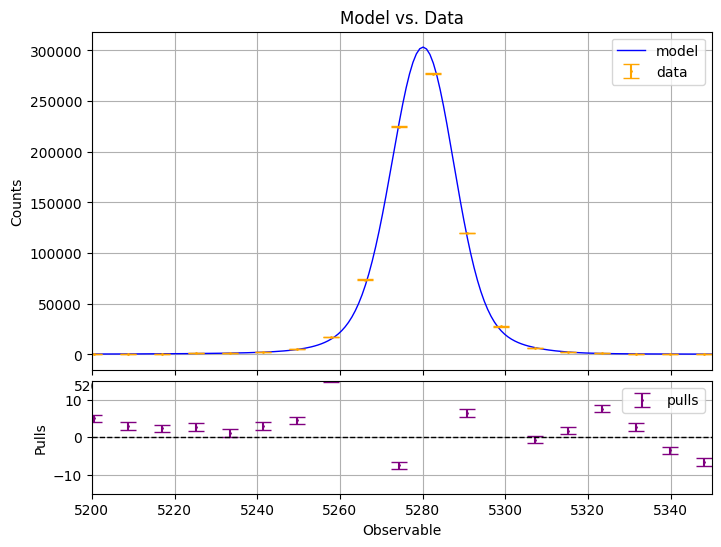

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_40, frac_cb1, frac_g1]] data=[<zfit.Data: Data obs=('mass',) shape=(764715, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.00024 │        2835472.19 |  7221.58 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name           value  (rounded)    at limit
-----------  ------------------  ----------
frac_g1                 0.75706       False
frac_cb1               0.122821       False
mu_g1                   5280.22       False
sigma_g1                7.14726       False
mu_cb1                  5284.37       False
sigma_cb1       

In [48]:
#Gaussian + Crystal Ball + Voigt
import zfit
import zfit_physics

# Define the mass space
mass_obs = zfit.Space('mass', limits=(5150, 5400))

# Parameters for the Gaussians
mu_g1 = zfit.Parameter('mu_g1', 5281, 5220, 5290)
sigma_g1 = zfit.Parameter('sigma_g1', 7.5, 0.1, 15)

mu_g2 = zfit.Parameter('mu_g2', 5278, 5250, 5295)
sigma_g2 = zfit.Parameter('sigma_g2', 47.9, 0.1, 50)

# Parameters for the Crystal Balls
mu_cb1 = zfit.Parameter('mu_cb1', 5284, 5220, 5400)
sigma_cb1 = zfit.Parameter('sigma_cb1', 13.9, 0.1, 55)
alpha_cb1 = zfit.Parameter('alpha_cb1', 13.6, 0.1, 20)
n_cb1 = zfit.Parameter('n_cb1', 34.1, 0.1, 100)

mu_cb2 = zfit.Parameter('mu_cb2', 5286, 5279, 5295)
sigma_cb2 = zfit.Parameter('sigma_cb2', 5.1, 0.1, 15)
alpha_cb2 = zfit.Parameter('alpha_cb2', 3.3, 0.1, 10)
n_cb2 = zfit.Parameter('n_cb2', 22.0, 0.1, 50)

# Parameters for the Voigt profile
mu_voigt = zfit.Parameter('mu_voigt', 5272, 5260, 5290)
sigma_voigt = zfit.Parameter('sigma_voigt', 5.8, 0.1, 15)
gamma_voigt = zfit.Parameter('gamma_voigt', 7.0, 0, 50)

# Fractions for the model (the sum of fractions should be 1)
frac_g1 = zfit.Parameter('frac_g1', 0.76, 0, 1)
frac_g2 = zfit.Parameter('frac_g2', 0.001, 0, 1)
frac_cb1 = zfit.Parameter('frac_cb1', 0.12, 0, 1)
frac_cb2 = zfit.Parameter('frac_cb2', 0.005, 0, 1)

# Define the PDFs (Gaussians, Crystal Balls, Voigt)
Gauss1 = zfit.pdf.Gauss(obs=mass_obs, mu=mu_g1, sigma=sigma_g1)
Gauss2 = zfit.pdf.Gauss(obs=mass_obs, mu=mu_g2, sigma=sigma_g2)

CrystalBall1 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb1, sigma=sigma_cb1, alpha=alpha_cb1, n=n_cb1)
CrystalBall2 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb2, sigma=sigma_cb2, alpha=alpha_cb2, n=n_cb2)

Voigt = zfit.pdf.Voigt(obs=mass_obs, m=mu_voigt, sigma=sigma_voigt, gamma=gamma_voigt)

# Supermodel (sum of all components)
supermodel_composite = zfit.pdf.SumPDF([Gauss1, Gauss2, CrystalBall1, CrystalBall2, Voigt],
                                      [frac_g1, frac_g2, frac_cb1, frac_cb2])

# Loss function (Unbinned NLL)
nll_composite = zfit.loss.UnbinnedNLL(model=supermodel_composite, data=simu_data_zfit)

# Minimizer
test_model = zfit.pdf.SumPDF([Gauss1, CrystalBall1, Voigt], [frac_g1, frac_cb1])
test_nll = zfit.loss.UnbinnedNLL(model=test_model, data=simu_data_zfit)
test_minimizer = zfit.minimize.Minuit()
test_result = test_minimizer.minimize(loss=test_nll)


# Plot result
plot_model_with_pulls(supermodel_composite, simu_data_zfit, 5200, 5350, nbins=100)
print(test_result)


/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_977/1057157104.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


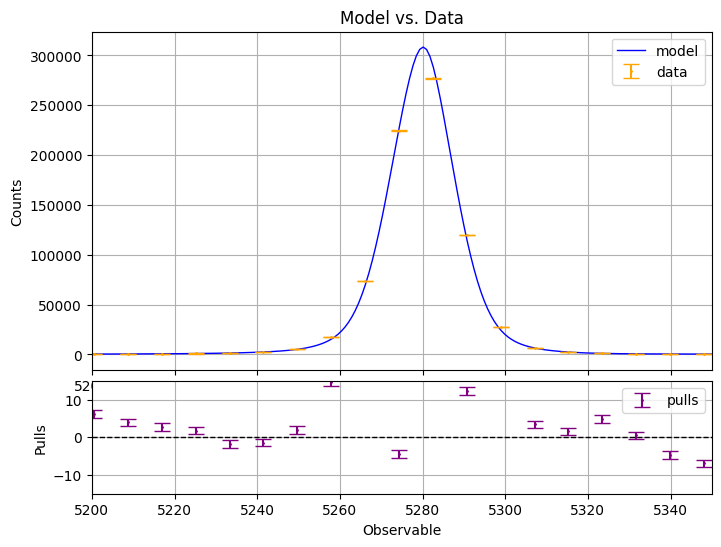

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[CB_frac, Composed_autoparam_26, Gauss_frac]] data=[<zfit.Data: Data obs=('mass',) shape=(764715, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 0.00047 │       2835445.86 |  7100.886 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name          value  (rounded)    at limit
----------  ------------------  ----------
Gauss_frac            0.723073       False
CB_frac               0.155336       False
mu_g                   5279.88       False
sigma_g                7.58053       False
mu_cb                  5279.08       False
sigma_cb             

In [40]:
#Gaussian+CrystalBall+BreitWigner
# Parameters for the model
mu_g = zfit.Parameter('mu_g', 5279.8, 5279, 5290)
sigma_g = zfit.Parameter('sigma_g', 7.6, 0.1, 15)

mu_cb = zfit.Parameter('mu_cb', 5279, 5279, 5290)
sigma_cb = zfit.Parameter('sigma_cb', 14.7, 0.1, 30)
alpha_cb = zfit.Parameter('alpha_cb', 1.8, 0.1, 10)
n_cb = zfit.Parameter('n_cb', 3.9, 0.1, 59)

bw_mass = zfit.Parameter('bw_mass', 5280, 5275, 5300)
bw_width = zfit.Parameter('bw_width', 11.3, 0, 30)

# Gaussian, Crystal Ball, and Breit-Wigner PDFs
Gauss = zfit.pdf.Gauss(obs=mass_obs, mu=mu_g, sigma=sigma_g)
CrystalBall = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb, sigma=sigma_cb, alpha=alpha_cb, n=n_cb)
BreitWigner = zfit_physics.pdf.RelativisticBreitWigner(obs=mass_obs, m=bw_mass, gamma=bw_width)

# Fractions for the model
Gauss_frac = zfit.Parameter('Gauss_frac', 0.72, 0, 1)
CB_frac = zfit.Parameter('CB_frac', 0.15, 0, 1)

# Sum of all distributions
supermodel = zfit.pdf.SumPDF([Gauss, CrystalBall, BreitWigner], [Gauss_frac, CB_frac])

# Loss function
nll = zfit.loss.UnbinnedNLL(model=supermodel, data=simu_data_zfit)

# Minimizer
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll)

# Plot result
plot_model_with_pulls(supermodel, simu_data_zfit, 5200, 5350, nbins=100)

print(result)


/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_977/1057157104.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


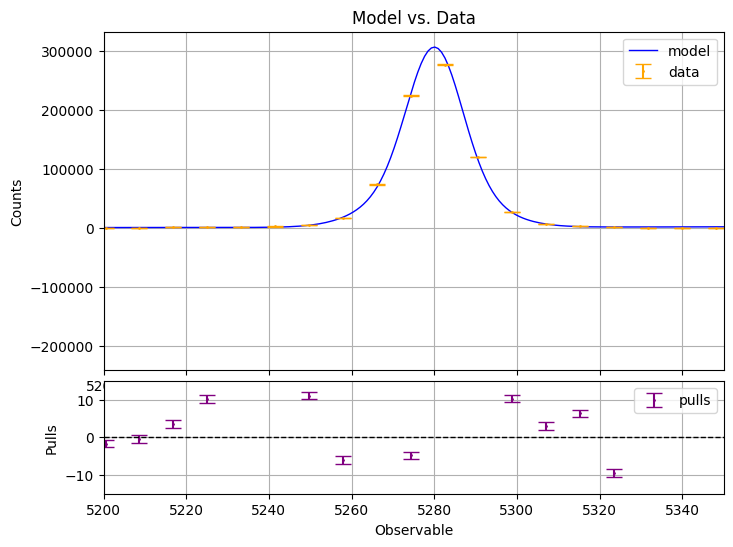

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_77, frac_exp_pos, frac_g1, frac_g2]] data=[<zfit.Data: Data obs=('mass',) shape=(764715, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═══════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm  │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═══════╪══════════════════════════════╡
│  False  │    True     │      False       │  1.6  │       2831336.71 | -145654.6 │
╘═════════╧═════════════╧══════════════════╧═══════╧══════════════════════════════╛

Parameters
name            value  (rounded)    at limit
------------  ------------------  ----------
frac_g1                  0.56968       False
frac_g2                 0.406181       False
frac_exp_pos            0.181433       False
mu_g1                    5280.13       False
sigma_g1                 6.49501       False
mu_g2 

In [70]:
import zfit
import numpy as np
import matplotlib.pyplot as plt

# Define observable
mass_obs = zfit.Space('mass', limits=(5200, 5350))

# Parameters for the model
mu_g1 = zfit.Parameter('mu_g1', 5279, 5279, 5290)
sigma_g1 = zfit.Parameter('sigma_g1', 7.3, 0.1, 15)

mu_g2 = zfit.Parameter('mu_g2', 5273, 5270, 5295)
sigma_g2 = zfit.Parameter('sigma_g2', 16.0, 0.1, 50)

# Exponential tails (ensure strictly positive values)
lambda_pos = zfit.Parameter('lambda_pos', 0.01, 0.01, 1)  # Reduced default value
lambda_neg = zfit.Parameter('lambda_neg', 0.01, 0.01, 1)  # Now strictly positive

# Gaussian PDFs
Gauss1 = zfit.pdf.Gauss(obs=mass_obs, mu=mu_g1, sigma=sigma_g1)
Gauss2 = zfit.pdf.Gauss(obs=mass_obs, mu=mu_g2, sigma=sigma_g2)

# Exponential PDFs (fixed negative lambda)
Exponential_pos = zfit.pdf.Exponential(obs=mass_obs, lambda_=lambda_pos)
Exponential_neg = zfit.pdf.Exponential(obs=mass_obs, lambda_=lambda_neg)  # No more negative lambda

# Fractions for the model
frac_g1 = zfit.Parameter('frac_g1', 0.52, 0, 1)
frac_g2 = zfit.Parameter('frac_g2', 0.16, 0, 1)
frac_exp_pos = zfit.Parameter('frac_exp_pos', 0.05, 0, 0.2)
frac_exp_neg = zfit.Parameter('frac_exp_neg', 0.001, 0, 0.2)

# Sum of all distributions
supermodel = zfit.pdf.SumPDF(
    [Gauss1, Gauss2, Exponential_pos, Exponential_neg],
    [frac_g1, frac_g2, frac_exp_pos]
)

# Generate some simulated data (assuming you have simu_data_zfit)
# simu_data_zfit = ... (Make sure this is correctly defined)

# Loss function
nll = zfit.loss.UnbinnedNLL(model=supermodel, data=simu_data_zfit)

# Minimizer
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll)

# Plot result
plot_model_with_pulls(supermodel, simu_data_zfit, 5200, 5350, nbins=100)

print(result)


/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_977/1057157104.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


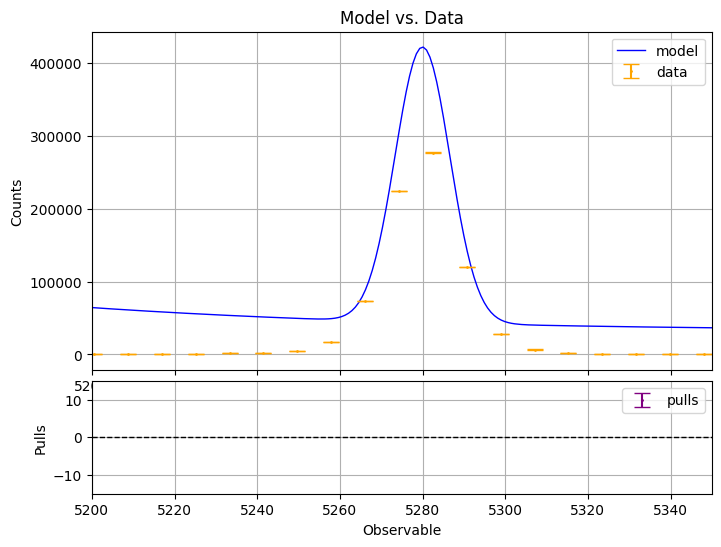

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[frac_cb, frac_exp_neg, frac_exp_pos]] data=[<zfit.Data: Data obs=('mass',) shape=(764715, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  False  │    True     │       True       │ 0.00016 │       2527674.44 | -827152.1 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name            value  (rounded)    at limit
------------  ------------------  ----------
frac_cb                        1        True
frac_exp_pos                   1        True
frac_exp_neg                   1        True
mu_cb                       5280       False
sigma_cb                 6.61113       False
alpha_cb      

In [32]:
#Crystal Ball + Exponential
# Parameters for the model
mu_cb = zfit.Parameter('mu_cb', 5279, 5279, 5290)
sigma_cb = zfit.Parameter('sigma_cb', 15.0, 0.1, 30)
alpha_cb = zfit.Parameter('alpha_cb', 2.0, 0.1, 10)
n_cb = zfit.Parameter('n_cb', 5.0, 0.1, 50)

lambda_pos = zfit.Parameter('lambda_pos', 0.01, 0, 1)
lambda_neg = zfit.Parameter('lambda_neg', 0.01, 0, 1)

# Crystal Ball and Exponentials
CrystalBall = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb, sigma=sigma_cb, alpha=alpha_cb, n=n_cb)
Exponential_pos = zfit.pdf.Exponential(obs=mass_obs, lambda_=lambda_pos)
Exponential_neg = zfit.pdf.Exponential(obs=mass_obs, lambda_=-lambda_neg)

# Fractions for the model
frac_cb = zfit.Parameter('frac_cb', 0.5, 0, 1)
frac_exp_pos = zfit.Parameter('frac_exp_pos', 0.3, 0, 1)
frac_exp_neg = zfit.Parameter('frac_exp_neg', 0.2, 0, 1)

# Sum of distributions
supermodel = zfit.pdf.SumPDF([CrystalBall, Exponential_pos, Exponential_neg],
                             [frac_cb, frac_exp_pos, frac_exp_neg])

# Loss function
nll = zfit.loss.UnbinnedNLL(model=supermodel, data=simu_data_zfit)

# Minimizer
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll)

# Plot result
plot_model_with_pulls(supermodel, simu_data_zfit, 5200, 5350, nbins=100)

print(result)


/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_977/1057157104.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


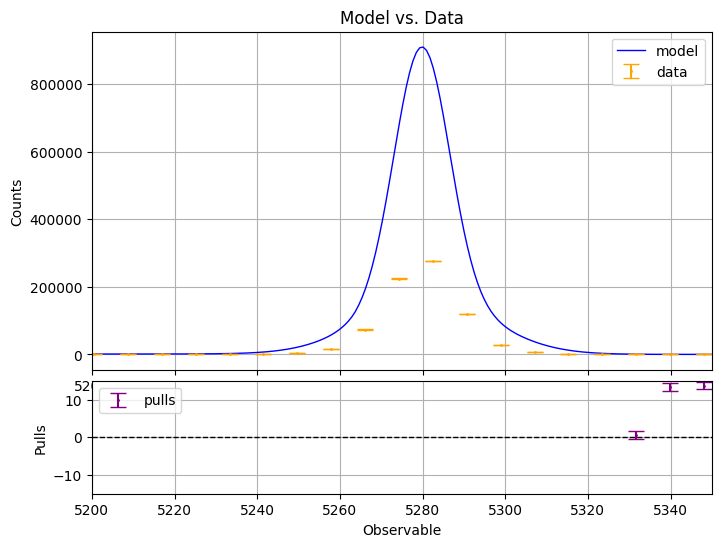

FitResult of
<UnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[frac_cb1, frac_cb2, frac_gauss]] data=[<zfit.Data: Data obs=('mass',) shape=(764715, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪════════╪══════════════════════════════╡
│  False  │    True     │       True       │ 0.0011 │        2059986.05 | -1157839 │
╘═════════╧═════════════╧══════════════════╧════════╧══════════════════════════════╛

Parameters
name          value  (rounded)    at limit
----------  ------------------  ----------
frac_cb1                     1        True
frac_cb2                     1        True
frac_gauss                   1        True
mu_cb1                 5280.51       False
sigma_cb1              6.40272       False
alpha_cb1              2.60128       F

In [33]:
#Double Crystal Ball + Gaussian
# Parameters for the model
mu_cb1 = zfit.Parameter('mu_cb1', 5279, 5279, 5290)
sigma_cb1 = zfit.Parameter('sigma_cb1', 7.22, 0.1, 15)
alpha_cb1 = zfit.Parameter('alpha_cb1', 2.0, 0.1, 10)
n_cb1 = zfit.Parameter('n_cb1', 5.0, 0.1, 50)

mu_cb2 = zfit.Parameter('mu_cb2', 5280, 5279, 5295)
sigma_cb2 = zfit.Parameter('sigma_cb2', 5.0, 0.1, 15)
alpha_cb2 = zfit.Parameter('alpha_cb2', 2.0, 0.1, 10)
n_cb2 = zfit.Parameter('n_cb2', 5.0, 0.1, 50)

mu_g = zfit.Parameter('mu_g', 5279, 5279, 5290)
sigma_g = zfit.Parameter('sigma_g', 7.22, 0.1, 15)

# Double Crystal Ball and Gaussian
CrystalBall1 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb1, sigma=sigma_cb1, alpha=alpha_cb1, n=n_cb1)
CrystalBall2 = zfit.pdf.CrystalBall(obs=mass_obs, mu=mu_cb2, sigma=sigma_cb2, alpha=alpha_cb2, n=n_cb2)
Gauss = zfit.pdf.Gauss(obs=mass_obs, mu=mu_g, sigma=sigma_g)

# Fractions for the model
frac_cb1 = zfit.Parameter('frac_cb1', 0.4, 0, 1)
frac_cb2 = zfit.Parameter('frac_cb2', 0.4, 0, 1)
frac_gauss = zfit.Parameter('frac_gauss', 0.2, 0, 1)

# Sum of distributions
supermodel = zfit.pdf.SumPDF([CrystalBall1, CrystalBall2, Gauss], [frac_cb1, frac_cb2, frac_gauss])

# Loss function
nll = zfit.loss.UnbinnedNLL(model=supermodel, data=simu_data_zfit)

# Minimizer
minimizer_minuit = zfit.minimize.Minuit()
result = minimizer_minuit.minimize(loss=nll)

# Plot result
plot_model_with_pulls(supermodel, simu_data_zfit, 5200, 5350, nbins=100)

print(result)
